In [ ]:
# install github sdk and plotting library
%pip install PyGithub matplotlib keyring scipy pandas

In [12]:
from github import Github, WorkflowRun, WorkflowJob
import matplotlib.pyplot as plt
import keyring
from typing import List

# prompt for github login with browser
gh_token = keyring.get_password("gh-workflow-stats", "token")
g = Github(login_or_token=gh_token)

# get workflow runs
repo = g.get_repo("org/repo")
workflow_runs = repo.get_workflow_runs()

ci_runs: List[WorkflowRun.WorkflowRun] = []
for run in workflow_runs:
    if run.name == "CI":
        ci_runs.append(run)

# get build jobs for CI runs
jobs = ci_runs[0].jobs()

In [25]:
# Fetch job details for the runs
jobs: List[WorkflowJob.WorkflowJob] = []

for run in ci_runs:
    run_jobs = run.jobs()

    for job in run_jobs:
        if job.name == "build" and job.status == "completed":
            jobs.append(job)

In [184]:
import pandas as pd

workflow_runs_df = pd.DataFrame([{
    "run_id": run.id,
    "status": run.status,
    "conclusion": run.conclusion,
    "created_at": run.created_at,
} for run in ci_runs])

jobs_df = pd.DataFrame([{
    "run_id": job.run_id,
    "job_id": job.id,
    "status": job.status,
    "conclusion": job.conclusion,
    "started_at": job.started_at,
    "completed_at": job.completed_at,
} for job in jobs])

# save to csv
jobs_df.to_csv("ci_jobs.csv")
workflow_runs_df.to_csv("ci_runs.csv")

/var/folders/5b/v1xrjh0s6wn69d4rsf8tv3140000gn/T/ipykernel_76761/1208988439.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code_additions_and_dt.rename(columns={"Additions": "Changes"}, inplace=True)
/var/folders/5b/v1xrjh0s6wn69d4rsf8tv3140000gn/T/ipykernel_76761/1208988439.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code_deletions_del_dt.rename(columns={"Deletions": "Changes"}, inplace=True)


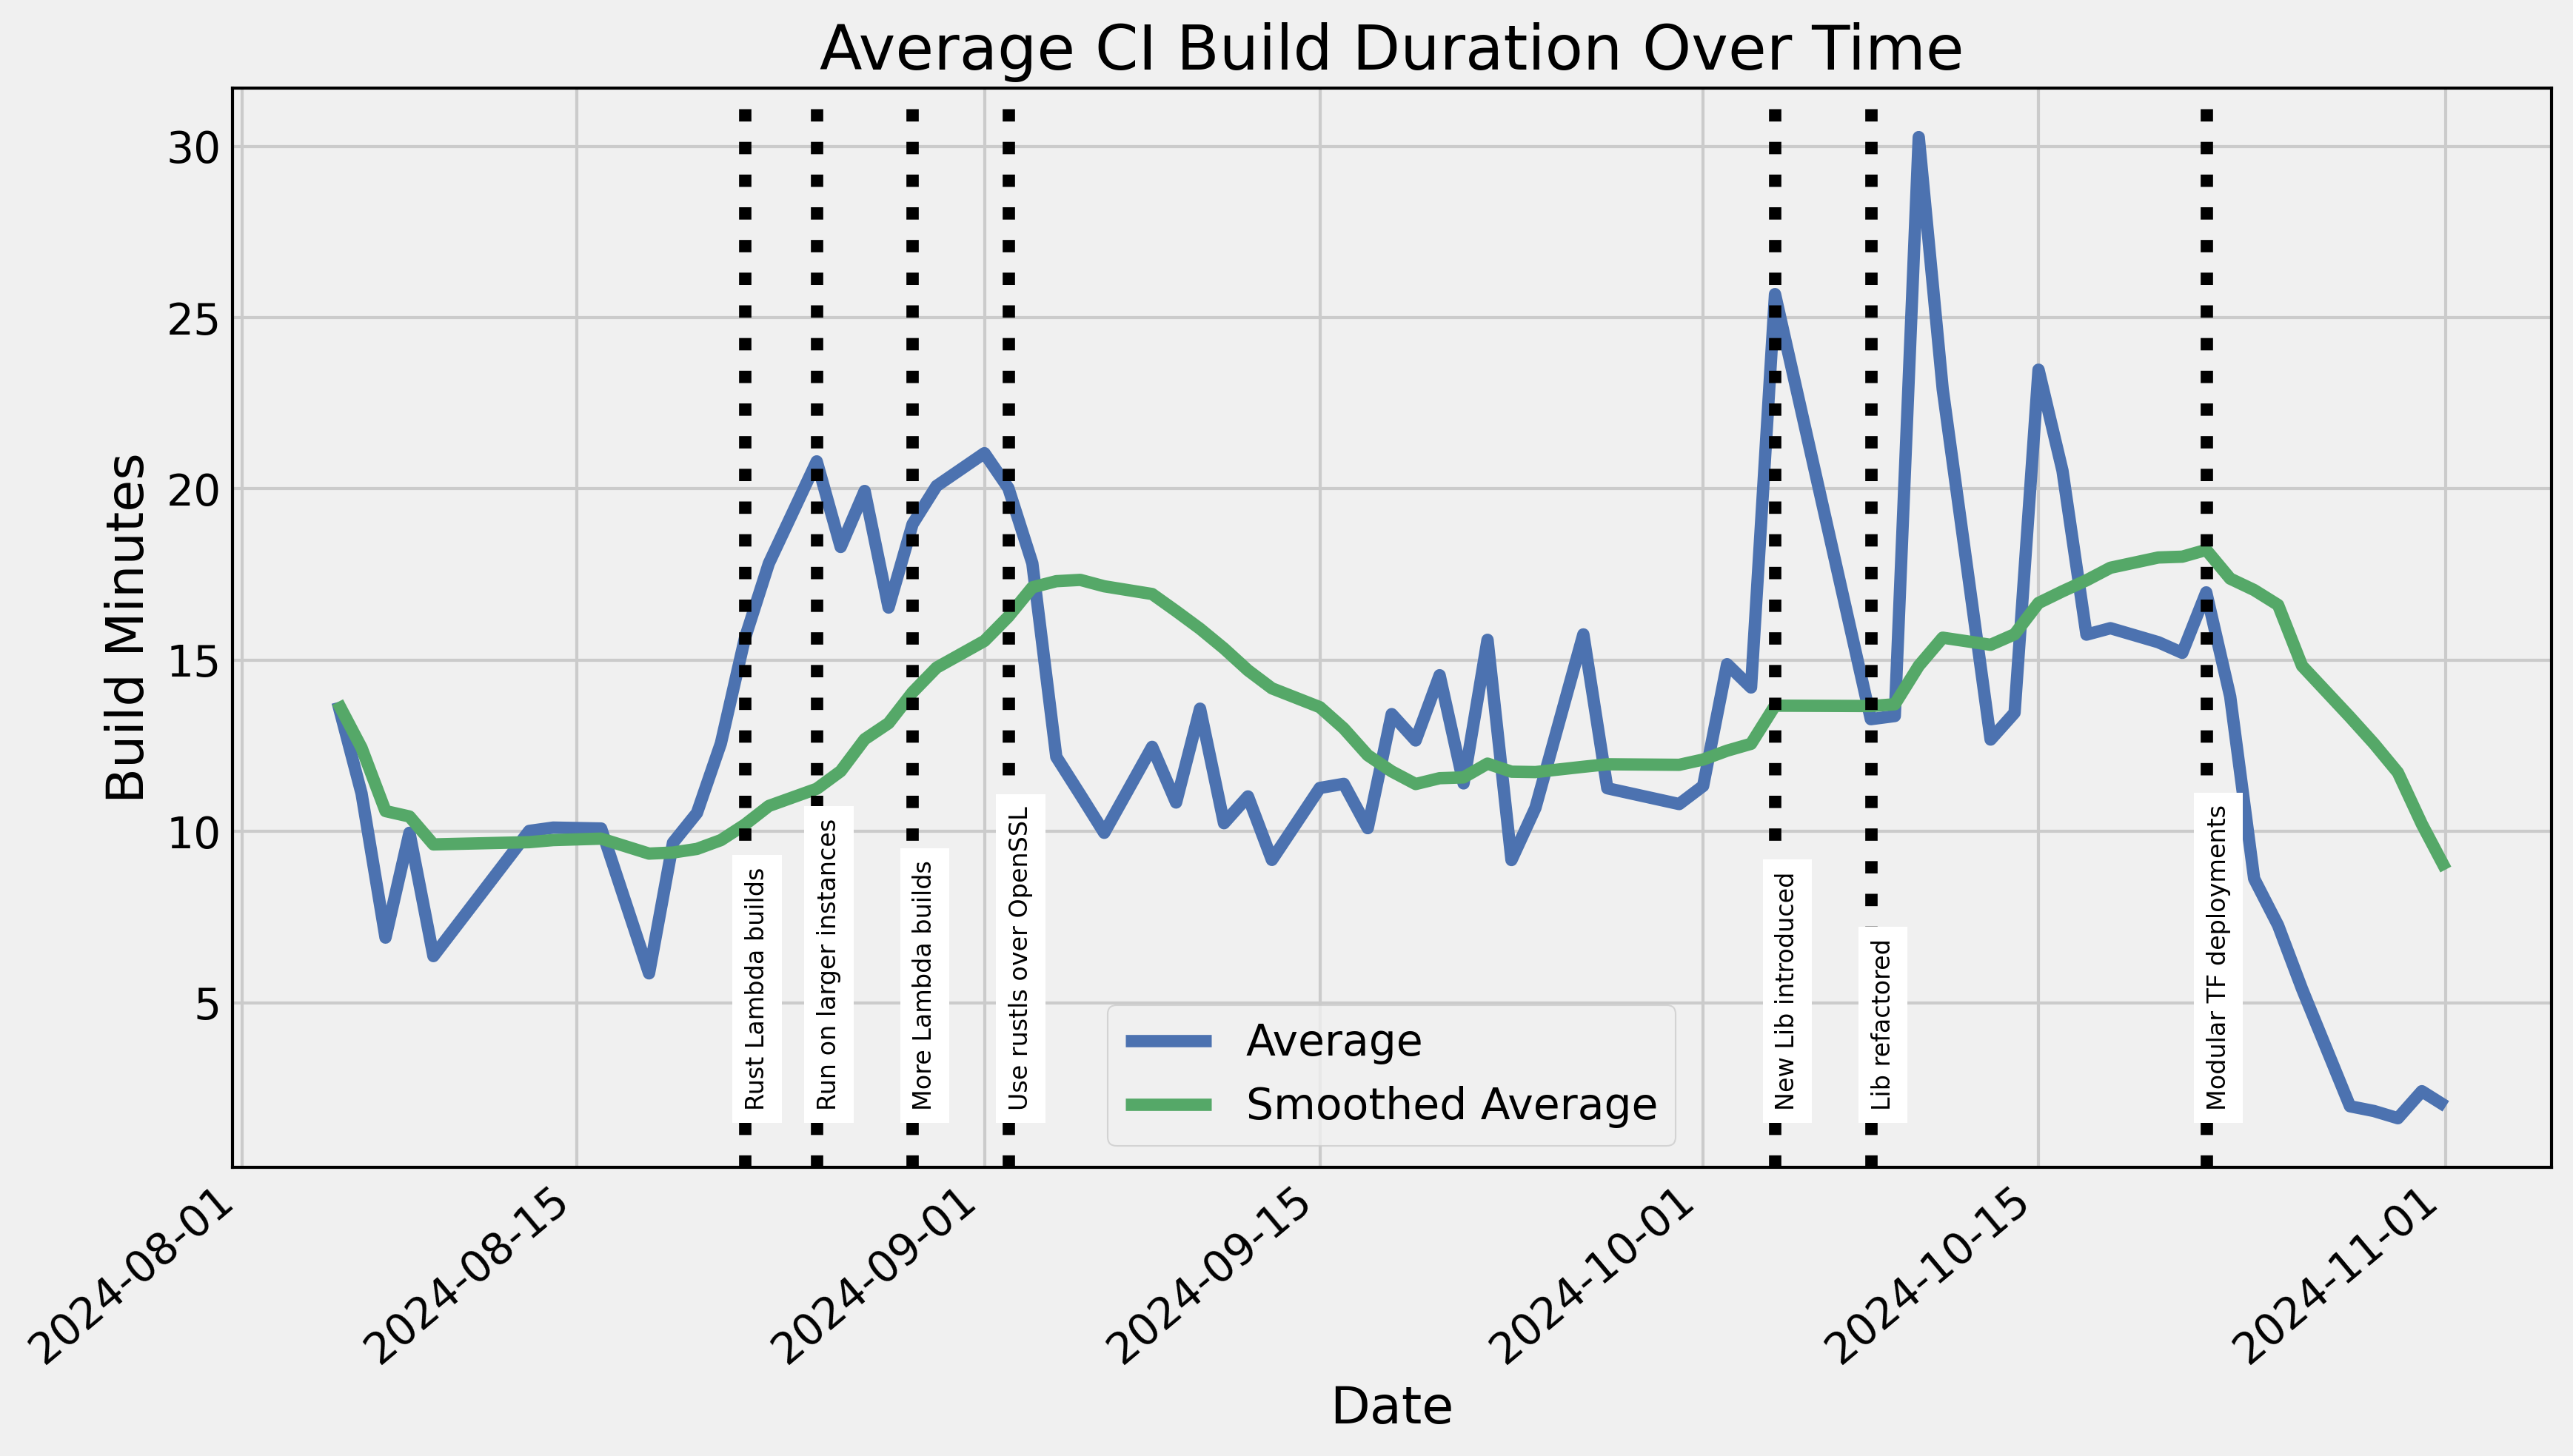

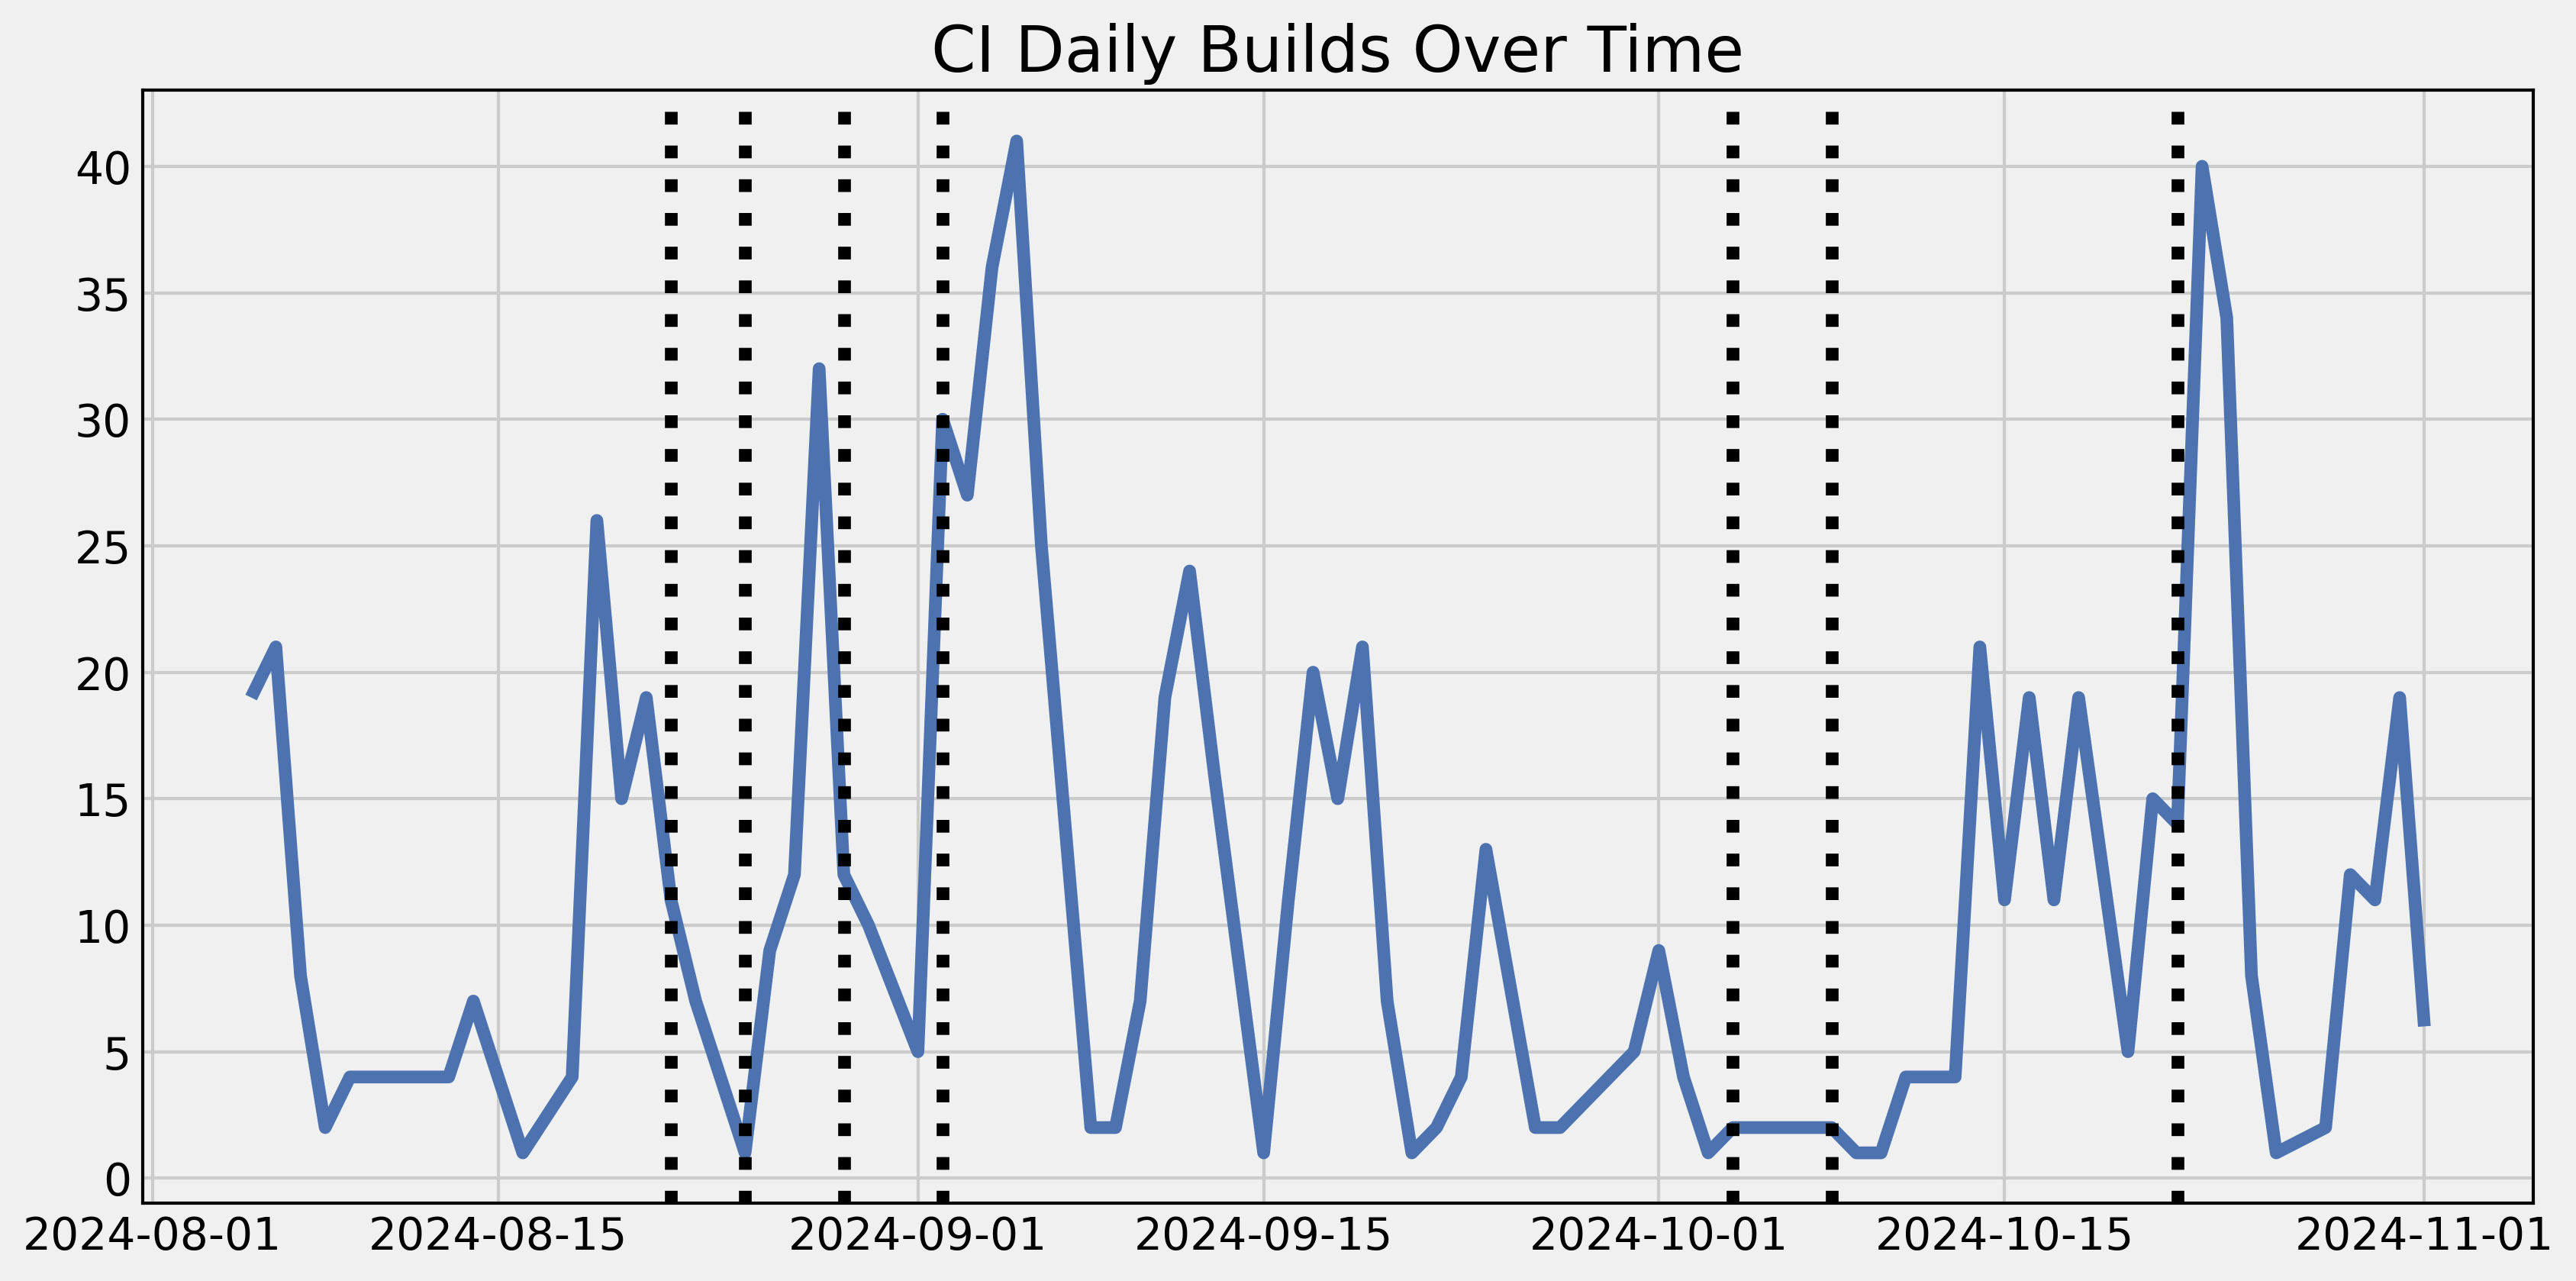

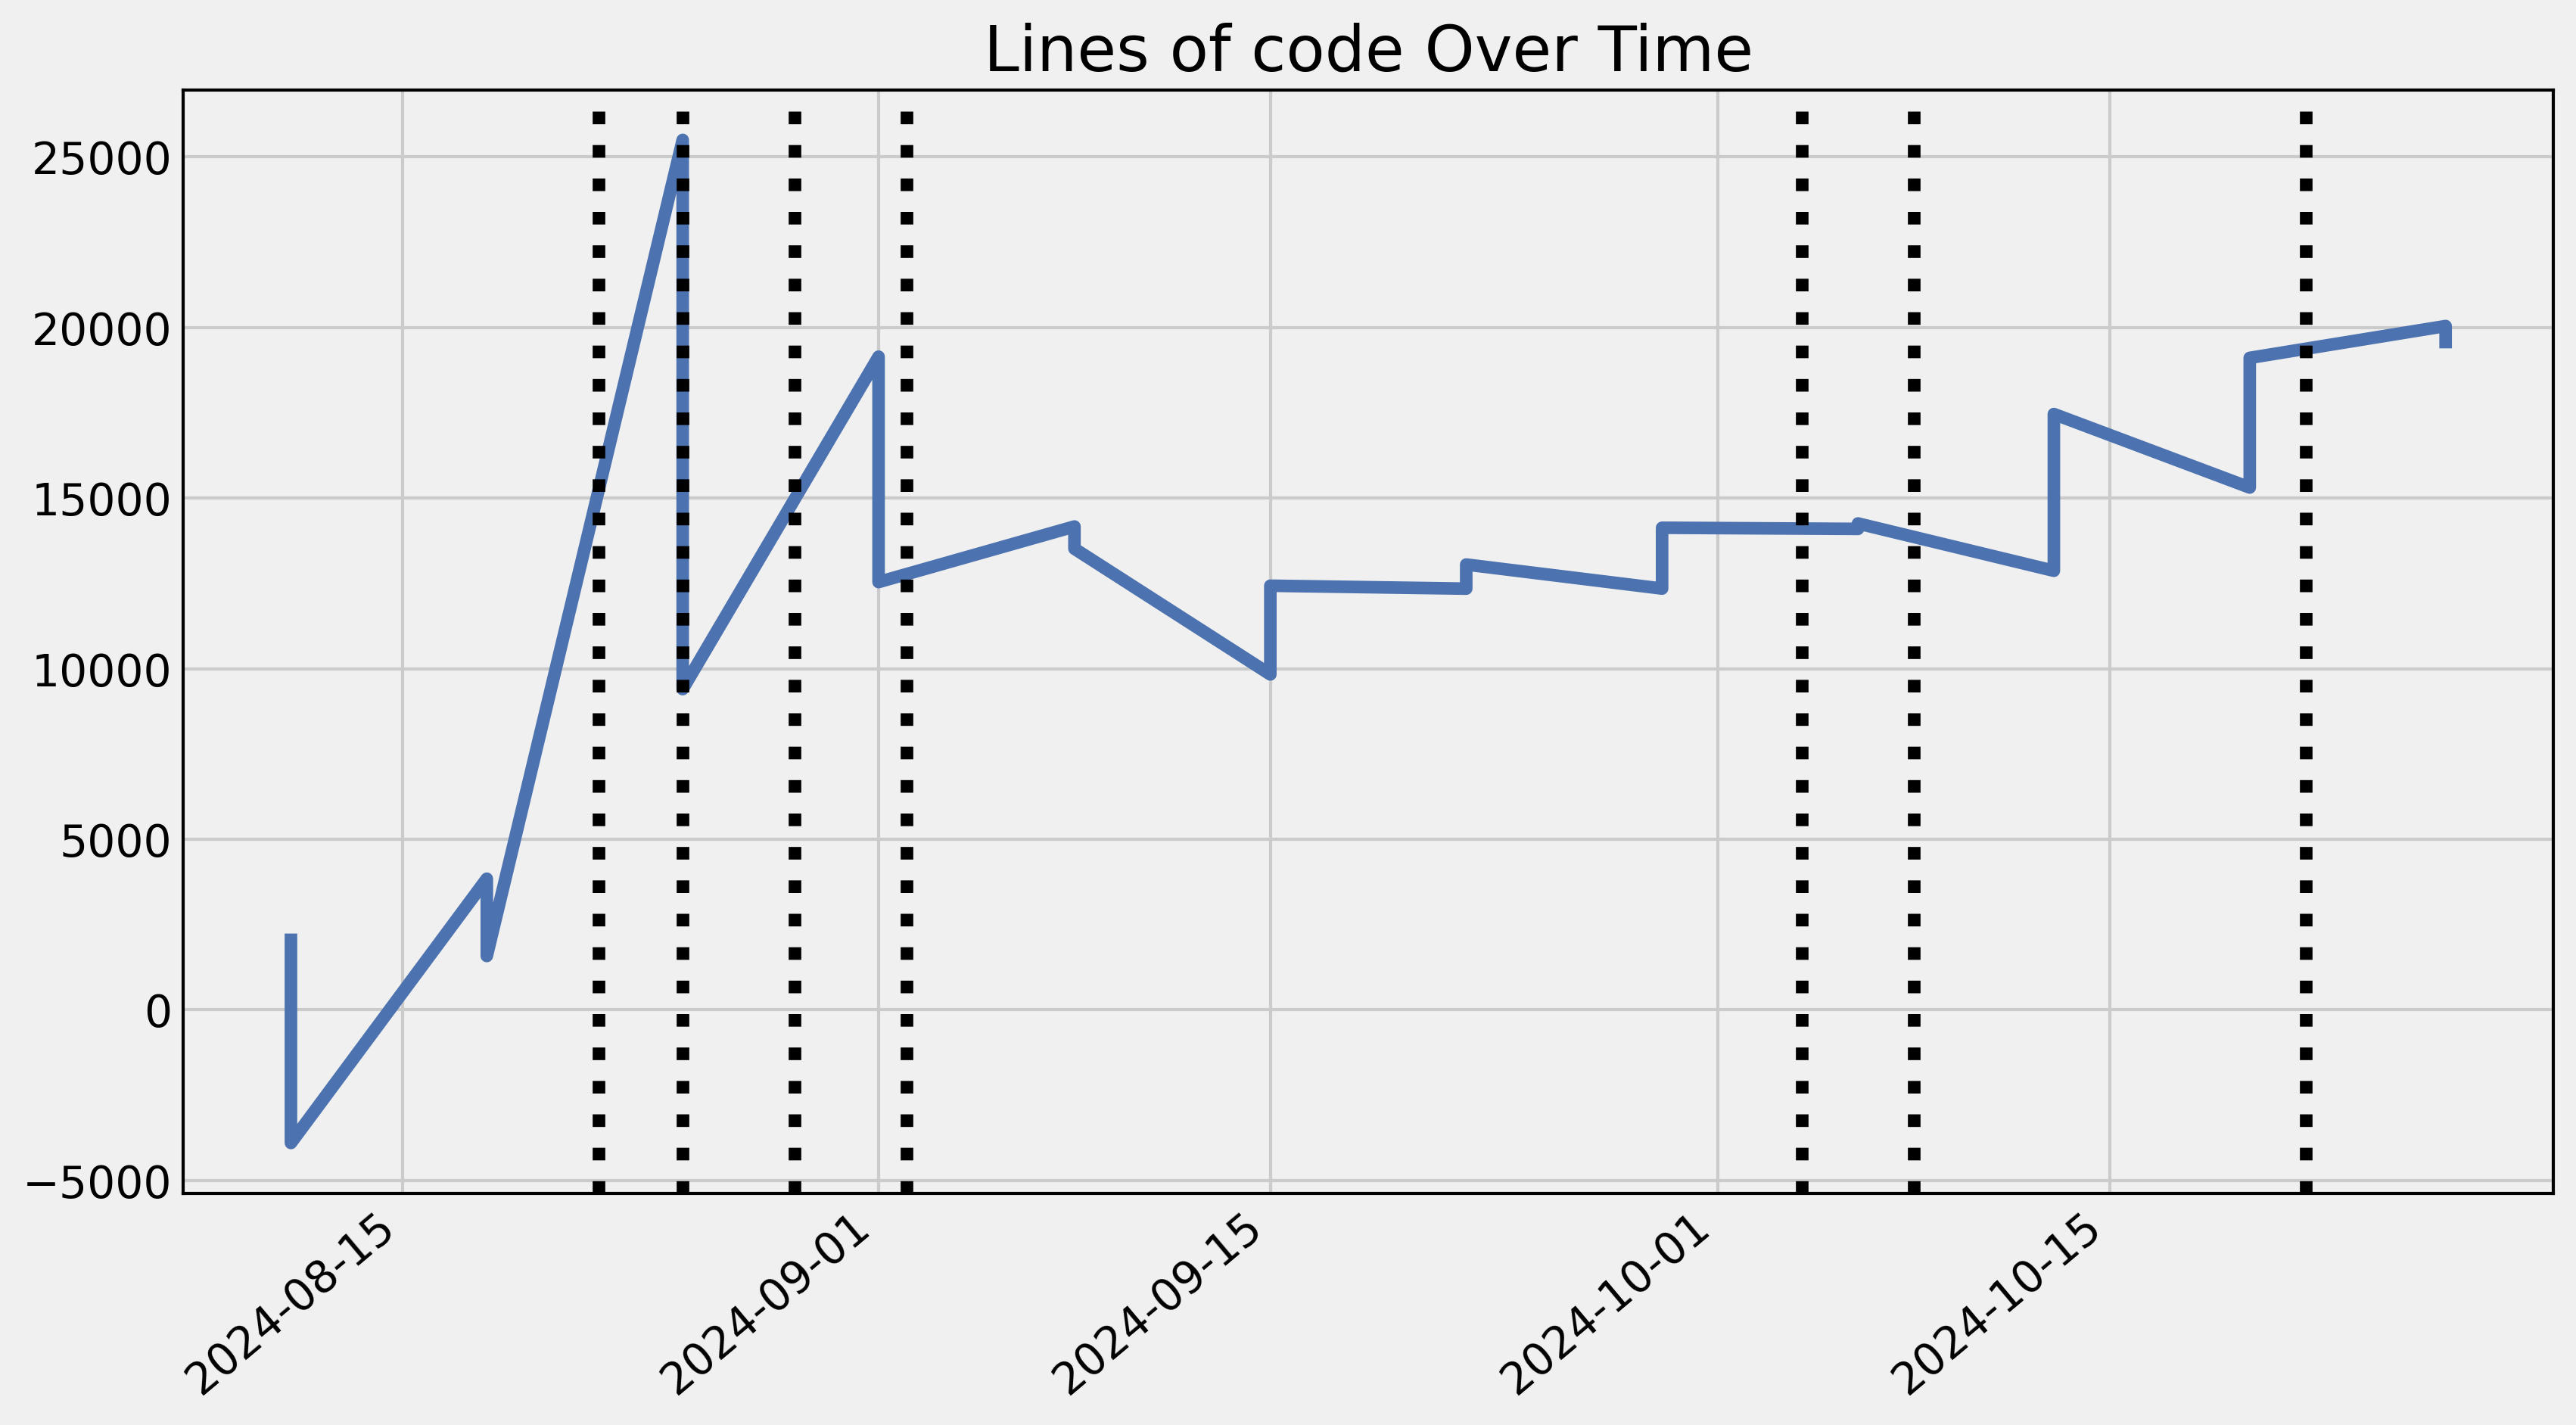

In [211]:
import pandas as pd

# use github like style with large canvas with border and no grid
plt.style.use('seaborn-v0_8-deep')
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.grid"] = True

# get job details
jobs_df = pd.read_csv("ci_jobs.csv")

# convert to datetime
jobs_df["started_at"] = pd.to_datetime(jobs_df["started_at"])
jobs_df["completed_at"] = pd.to_datetime(jobs_df["completed_at"])

# caldulate build time
jobs_df["build_time"] = ((jobs_df["completed_at"] - jobs_df["started_at"]).dt.seconds) / 60

# group by started_at data and calculate average build time
buildtime_df = jobs_df.groupby(
    jobs_df["started_at"].dt.date
).agg({
    "build_time": "mean"
}).reset_index()


# plot average build time over time
fig1, ax1 = plt.subplots()
ax1.plot(buildtime_df["started_at"], buildtime_df["build_time"])

# plot smoothed average build time over time, without a gap at the beginning
buildtime_df["smoothed_build_time"] = buildtime_df["build_time"].rolling(window=14, min_periods=1).mean()
ax1.plot(buildtime_df["started_at"], buildtime_df["smoothed_build_time"])

for label in ax1.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')

ax1.legend(["Average", "Smoothed Average"])
ax1.set_title("Average CI Build Duration Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Build Minutes")

# draw events
events = pd.DataFrame([
    {"date": "2024-08-22", "label": "Rust Lambda builds"},
    {"date": "2024-08-25", "label": "Run on larger instances"},
    {"date": "2024-08-29", "label": "More Lambda builds"},
    {"date": "2024-09-02", "label": "Use rustls over OpenSSL"},
    {"date": "2024-10-04", "label": "New Lib introduced"},
    {"date": "2024-10-08", "label": "Lib refactored"},
    {"date": "2024-10-22", "label": "Modular TF deployments"},
])

events["date"] = pd.to_datetime(events["date"])

for event in events.itertuples():
    ax1.axvline(event.date, linestyle=":")
    # with padding 
    ax1.text(event.date, 2, event.label, rotation=90, fontsize=8, bbox=dict(boxstyle='square,pad=0.5', facecolor='white', edgecolor='none'))


jobs_date_range = pd.date_range(buildtime_df["started_at"].min(), buildtime_df["started_at"].max())

# plot count of jobs over time
workflow_runs_df = pd.read_csv("ci_runs.csv")
workflow_runs_df["created_at"] = pd.to_datetime(pd.to_datetime(workflow_runs_df["created_at"]).dt.date)
workflow_runs_df = workflow_runs_df[workflow_runs_df["created_at"].isin(jobs_date_range)]

runs_per_day_df = workflow_runs_df.groupby(workflow_runs_df["created_at"].dt.date).size().reset_index()

fig2, ax2 = plt.subplots()
ax2.plot(runs_per_day_df["created_at"], runs_per_day_df[0])
ax2.set_title("CI Daily Builds Over Time")

for event in events.itertuples():
    ax2.axvline(event.date, linestyle=":")


# plot cumulative code frequency
# get code frequency details (downloaded from https://github.com/<org>/<repo>/graphs/code-frequency)
code_frequency_df = pd.read_csv("code_frequency.csv")

# calculate cumulative code frequency
code_frequency_df["DateTime"] = pd.to_datetime(code_frequency_df["DateTime"])
code_frequency_df = code_frequency_df[code_frequency_df["DateTime"].isin(jobs_date_range)]

code_additions_and_dt = code_frequency_df[["DateTime", "Additions"]]
code_additions_and_dt.rename(columns={"Additions": "Changes"}, inplace=True)
code_deletions_del_dt = code_frequency_df[["DateTime", "Deletions"]]
code_deletions_del_dt.rename(columns={"Deletions": "Changes"}, inplace=True)

code_frequency_df = pd.concat([code_additions_and_dt, code_deletions_del_dt])
code_frequency_df = code_frequency_df.sort_values(by="DateTime")
code_frequency_df["total_cumulative"] = code_frequency_df["Changes"].cumsum()


fig3, ax3 = plt.subplots()
ax3.plot(code_frequency_df["DateTime"], code_frequency_df["total_cumulative"])

for event in events.itertuples():
    ax3.axvline(event.date, linestyle=":")

for label in ax3.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')

ax3.set_title("Lines of code Over Time")

plt.show()